# DBT Avanzado:

<a id="section_toc"></a> 
## Tabla de Contenidos

[1. Seeds](#seeds)

[2. Tests](#tests)

[3. Documentación](#documentacion)

[4. Snapshots](#snapshots)

[5. Jinja, Macros y Paquetes](#jinja)


<a id="seeds"></a> 

# 1. Seeds

Las seeds son archivos de valores separados por comas (CSV) dentro de tu proyecto dbt que pueden cargarse en tu almacén de datos. Son ideales para conjuntos de datos pequeños e inmutables que tal vez no tengas un sistema de origen del cual extraer. Las seeds se almacenan, controlan por versiones y se revisan por código dentro de tu proyecto dbt, mientras que otros datos de origen se mantienen fuera de él.  Algunos buenos casos de uso serían tablas de mapeo como códigos de país a nombres de país, abreviaturas de estados de EE. UU. a nombres de estados de EE. UU., o algún otro tipo de mapeo estático, o crear listas de cosas que necesitas rastrear manualmente para incluir o excluir de las listas. Los malos casos de uso serían grandes conjuntos de datos cambiantes, cargar datos sin procesar que se exportaron a CSV o cualquier tipo de datos que contengan información confidencial.

A continuación, se incluyen algunos aspectos a considerar al decidir si usar seeds en tu proyecto dbt:

* **Frescura de datos:** Las seeds se usan normalmente para insertar un conjunto de datos en una base de datos y no están destinadas a modificarse o actualizarse regularmente. Esto significa que no es probable que los datos de una seed cambien mucho con el tiempo. Si necesitas actualizar los datos con regularidad, es posible que las seeds no sean la mejor opción, ya que crearías mucho trabajo manual adicional.

* **Volumen de datos:** Las seeds están pensadas para pequeñas cantidades de datos iniciales que se necesitan para configurar una base de datos. Si tienes una gran cantidad de datos que deben cargarse en tu base de datos de forma regular, las seeds pueden no ser la opción más eficiente. En su lugar, es posible que quieras considerar usar otra opción. Como regla general, creemos que las seeds no deben tener más de 5000 filas. Además, cuando los archivos seed superan 1 MB, dbt no puede realizar la comparación de estado de la suma de comprobación.

* **Dependencias de datos:** Las seeds se utilizan a menudo para configurar datos de referencia que necesitan los modelos posteriores. Si tus modelos dependen de datos que cambian con frecuencia o se actualizan de forma regular, las seeds no son la mejor opción.

En dbt, las seeds se almacenan normalmente en el directorio `seeds` de tu proyecto dbt y se materializan como tablas en tu almacén. Hay un comando separado que debes ejecutar para completar tus tablas con datos seed llamado `dbt seed`. Cuando ejecutas `dbt seed`, dbt leerá del directorio seed y creará tus tablas. `dbt build` también construirá automáticamente tus seeds cuando se ejecute.

## Ejecutando Seeds

Para construir tus datos seed en tu almacén de datos, simplemente necesitas ejecutar `dbt seed`. Este comando cargará todos los archivos CSV ubicados en el directorio `seeds-path` de tu proyecto dbt. Al igual que el comando `dbt run`, también puedes agregar la bandera `--select` para limitar la construcción a solo un archivo seed específico.

El comando `dbt build` también crea seeds automáticamente, por lo que no tienes que ejecutar el comando `dbt seed` junto con él. Como siempre, dbt construye tu DAG y construirá las seeds antes de que cualquier modelo posterior pueda usarlas.


## Ejemplo de Seeds en el proyecto de MercadoLibre:


### 1). Establecer el path al "directorio raiz" del proyecto

In [1]:
import os

# Cambiar el directorio de trabajo a dos niveles arriba
os.chdir(os.path.join(os.getcwd(), "../.."))

# Verificar el nuevo directorio de trabajo
print("El nuevo directorio de trabajo es:", os.getcwd())

El nuevo directorio de trabajo es: /home/juan/UCCuyo/BaseDeDatos2024


## 2). Conectarse a la base DuckDB que tiene los datos de meracdolibre

In [3]:
import duckdb
base = duckdb.connect('mercado_libre.duckdb')

In [6]:
base.sql('''
SELECT *
FROM information_schema.tables
WHERE table_schema='main_silver'
''')

┌───────────────┬──────────────┬───────────────────┬────────────┬──────────────────────────────┬──────────────────────┬───────────────────────────┬──────────────────────────┬────────────────────────┬────────────────────┬──────────┬───────────────┬───────────────┐
│ table_catalog │ table_schema │    table_name     │ table_type │ self_referencing_column_name │ reference_generation │ user_defined_type_catalog │ user_defined_type_schema │ user_defined_type_name │ is_insertable_into │ is_typed │ commit_action │ TABLE_COMMENT │
│    varchar    │   varchar    │      varchar      │  varchar   │           varchar            │       varchar        │          varchar          │         varchar          │        varchar         │      varchar       │ varchar  │    varchar    │    varchar    │
├───────────────┼──────────────┼───────────────────┼────────────┼──────────────────────────────┼──────────────────────┼───────────────────────────┼──────────────────────────┼────────────────────────┼─────────

In [14]:
base.sql('''
SELECT *
FROM main_silver.search     
LIMIT 2                                          
''')

┌───────────────┬─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┬───────────┬────────────────────┬─────────────────┬─────────────┬───────────────┬───────────┬────────────────┬──────────────────────┬────────────────────┬────────────────────┬────────────┬──────────────────┬────────────────────┬────────────────┬──────────────┐
│      id       │                                                          title                                                          │ condition │ catalog_product_id │ listing_type_id │ category_id │   domain_id   │   price   │ original_price │ sale_price__price_id │ sale_price__amount │ available_quantity │ seller__id │ seller__nickname │    _dlt_load_id    │    _dlt_id     │ product_type │
│    varchar    │                                                         varchar                                                         │  varchar  │      varchar       │     varchar     │   varchar

Acá podemos ver que una de las columnas de la tabla silver que creamos la clase pasada es "Category ID" y para las dos primeras filas tiene el valor de "MLA1652". Sin embargo, no sabemos a que categoría está haciendo referencia. Podríamos obtener una tabla chica con cada categoría y su respectivo nombre para saberlo y guardarla como una "seed". Esto se puede obtener facilmente haciendo un get a un endpoint de la api sin la necesidad de autenticarse

## 3). Descargar la tabla de categorías desde la API

In [ ]:
import requests
import json
import pandas as pd

# URL para obtener las categorías
url = "https://api.mercadolibre.com/sites/MLA/categories"

# Realizar la solicitud
response = requests.get(url)

# Guardar en un archivo JSON si la solicitud fue exitosa
if response.status_code == 200:
    categories_data = response.json()
    categories_df = pd.DataFrame(categories_data)

In [17]:
categories_df

,id,name
0,MLA5725,Accesorios para Vehículos
1,MLA1512,Agro
2,MLA1403,Alimentos y Bebidas
3,MLA1071,Animales y Mascotas
4,MLA1367,Antigüedades y Colecciones
5,MLA1368,"Arte, Librería y Mercería"
6,MLA1743,"Autos, Motos y Otros"
7,MLA1384,Bebés
8,MLA1246,Belleza y Cuidado Personal
9,MLA1039,Cámaras y Accesorios


### 4). Guardar la tabla creada en el directorio de "Seeds" 

In [ ]:
categories_df.to_csv('ml_transformations/seeds/mla_categories.csv', index=False)

### 5). Ejecutar el comando de "dbt seed"

Primero hay que cerrar la conexión con la base antes de ejecutar cualquier comando de dbt

In [19]:
base.close()

Ejecutar el comando:

```powershell
01-bases-de-datos-py3.11juan@BOOK-NFF0K06361:~/UCCuyo/BaseDeDatos2024/ml_transformations$ dbt seed
18:07:42  Running with dbt=1.8.0
18:07:42  Registered adapter: duckdb=1.9.0
18:07:42  Found 6 models, 4 data tests, 1 seed, 9 sources, 416 macros
18:07:42  
18:07:42  Concurrency: 1 threads (target='dev')
18:07:42  
18:07:42  1 of 1 START seed file main.mla_categories ..................................... [RUN]
18:07:43  1 of 1 OK loaded seed file main.mla_categories ................................. [INSERT 32 in 0.14s]
18:07:43  
18:07:43  Finished running 1 seed in 0 hours 0 minutes and 0.38 seconds (0.38s).
18:07:43  
18:07:43  Completed successfully
18:07:43  
18:07:43  Done. PASS=1 WARN=0 ERROR=0 SKIP=0 TOTAL=1
```

### 6). Corroborar que la tabla se haya creado:


In [20]:
base = duckdb.connect('mercado_libre.duckdb')

In [22]:
base.sql('''
SELECT *
FROM information_schema.tables
WHERE table_name LIKE '%mla_categories%'
''')

┌───────────────┬──────────────┬────────────────┬────────────┬──────────────────────────────┬──────────────────────┬───────────────────────────┬──────────────────────────┬────────────────────────┬────────────────────┬──────────┬───────────────┬───────────────┐
│ table_catalog │ table_schema │   table_name   │ table_type │ self_referencing_column_name │ reference_generation │ user_defined_type_catalog │ user_defined_type_schema │ user_defined_type_name │ is_insertable_into │ is_typed │ commit_action │ TABLE_COMMENT │
│    varchar    │   varchar    │    varchar     │  varchar   │           varchar            │       varchar        │          varchar          │         varchar          │        varchar         │      varchar       │ varchar  │    varchar    │    varchar    │
├───────────────┼──────────────┼────────────────┼────────────┼──────────────────────────────┼──────────────────────┼───────────────────────────┼──────────────────────────┼────────────────────────┼────────────────────┼

In [23]:
base.sql('''
SELECT *
FROM main.mla_categories
''')

┌───────────┬───────────────────────────────┐
│    id     │             name              │
│  varchar  │            varchar            │
├───────────┼───────────────────────────────┤
│ MLA5725   │ Accesorios para Vehículos     │
│ MLA1512   │ Agro                          │
│ MLA1403   │ Alimentos y Bebidas           │
│ MLA1071   │ Animales y Mascotas           │
│ MLA1367   │ Antigüedades y Colecciones    │
│ MLA1368   │ Arte, Librería y Mercería     │
│ MLA1743   │ Autos, Motos y Otros          │
│ MLA1384   │ Bebés                         │
│ MLA1246   │ Belleza y Cuidado Personal    │
│ MLA1039   │ Cámaras y Accesorios          │
│    ·      │          ·                    │
│    ·      │          ·                    │
│    ·      │          ·                    │
│ MLA1182   │ Instrumentos Musicales        │
│ MLA3937   │ Joyas y Relojes               │
│ MLA1132   │ Juegos y Juguetes             │
│ MLA3025   │ Libros, Revistas y Comics     │
│ MLA1168   │ Música, Películas y 

## 7). Usar la nueva tabla:
Ahora que tenemos la nueva tabla, podemos adaptar el modelo de "search" para que la tabla incorpore el nombre de la categoría

In [24]:
base.close()

#### Cambiar el modelo de "search.sql" para que incorpore el nombre de la categoría:
```sql
-- Modelo 1: Unión de las tablas 'search' de los esquemas laptop, mini_pc y pc
{{ config(materialized='table') }}

WITH laptop_search AS (
    SELECT id, title, condition, catalog_product_id, listing_type_id, category_id, domain_id, price, original_price, 
           sale_price__price_id, sale_price__amount, available_quantity, seller__id, seller__nickname, _dlt_load_id, _dlt_id, 'laptop' AS product_type
    FROM {{ source('laptop', 'search') }}
),
mini_pc_search AS (
    SELECT id, title, condition, catalog_product_id, listing_type_id, category_id, domain_id, price, original_price, 
           sale_price__price_id, sale_price__amount, available_quantity, seller__id, seller__nickname, _dlt_load_id, _dlt_id, 'mini_pc' AS product_type
    FROM {{ source('mini_pc', 'search') }}
),
pc_search AS (
    SELECT id, title, condition, catalog_product_id, listing_type_id, category_id, domain_id, price, original_price, 
           sale_price__price_id, sale_price__amount, available_quantity, seller__id, seller__nickname, _dlt_load_id, _dlt_id, 'pc' AS product_type
    FROM {{ source('pc', 'search') }}
),

search as (

SELECT id, title, condition, catalog_product_id, listing_type_id, category_id, domain_id, price, original_price, 
       sale_price__price_id, sale_price__amount, available_quantity, seller__id, seller__nickname, _dlt_load_id, _dlt_id, product_type 
FROM laptop_search
UNION ALL
SELECT id, title, condition, catalog_product_id, listing_type_id, category_id, domain_id, price, original_price, 
       sale_price__price_id, sale_price__amount, available_quantity, seller__id, seller__nickname, _dlt_load_id, _dlt_id, product_type 
FROM mini_pc_search
UNION ALL
SELECT id, title, condition, catalog_product_id, listing_type_id, category_id, domain_id, price, original_price, 
       sale_price__price_id, sale_price__amount, available_quantity, seller__id, seller__nickname, _dlt_load_id, _dlt_id, product_type 
FROM pc_search

)
select 
       a.id, 
       a.title,
       a.condition, 
       a.catalog_product_id, 
       a.listing_type_id, 
       a.category_id, 
       b.name as category_name,  
       a.domain_id, 
       a.price, 
       a.original_price, 
       a.sale_price__price_id, 
       a.sale_price__amount, 
       a.available_quantity, 
       a.seller__id, 
       a.seller__nickname, 
       a._dlt_load_id, 
       a._dlt_id, 
       a.product_type

from search a
left join {{ref('mla_categories')}} b
       on a.category_id = b.id

```

#### Ejecutar "dbt run"

```powershell
01-bases-de-datos-py3.11juan@BOOK-NFF0K06361:~/UCCuyo/BaseDeDatos2024/ml_transformations$ dbt run
18:20:36  Running with dbt=1.8.0
18:20:36  Registered adapter: duckdb=1.9.0
18:20:36  Found 6 models, 4 data tests, 1 seed, 9 sources, 416 macros
18:20:36  
18:20:36  Concurrency: 1 threads (target='dev')
18:20:36  
18:20:36  1 of 6 START sql table model main.my_first_dbt_model ........................... [RUN]
18:20:36  1 of 6 OK created sql table model main.my_first_dbt_model ...................... [OK in 0.11s]
18:20:36  2 of 6 START sql table model main_silver.search ................................ [RUN]
18:20:36  2 of 6 OK created sql table model main_silver.search ........................... [OK in 0.11s]
18:20:36  3 of 6 START sql view model main_silver.search_attributes ...................... [RUN]
18:20:36  3 of 6 OK created sql view model main_silver.search_attributes ................. [OK in 0.08s]
18:20:36  4 of 6 START sql view model main_silver.seller ................................. [RUN]
18:20:37  4 of 6 OK created sql view model main_silver.seller ............................ [OK in 0.11s]
18:20:37  5 of 6 START sql view model main.my_second_dbt_model ........................... [RUN]
18:20:37  5 of 6 OK created sql view model main.my_second_dbt_model ...................... [OK in 0.07s]
18:20:37  6 of 6 START sql view model main_gold.publicaciones_con_i7 ..................... [RUN]
18:20:37  6 of 6 OK created sql view model main_gold.publicaciones_con_i7 ................ [OK in 0.08s]
18:20:37  
18:20:37  Finished running 2 table models, 4 view models in 0 hours 0 minutes and 0.84 seconds (0.84s).
18:20:37  
18:20:37  Completed successfully
18:20:37  
18:20:37  Done. PASS=6 WARN=0 ERROR=0 SKIP=0 TOTAL=6
```

<a id="tests"></a> 

# 2). Tests (Pruebas)

Las pruebas en dbt son esenciales para asegurar la calidad y confiabilidad de los datos.  Actúan como guardianes, verificando que los datos sean precisos, consistentes y que las transformaciones se comporten según lo esperado. dbt integra las pruebas en el proceso de construcción del modelo, lo que permite una evaluación continua de la integridad de los datos y transformaciones.

**¿Por qué realizar pruebas?**

* **Confianza en el código:**  Asegura que el código funciona correctamente y soporta escenarios reales.

* **Validación a lo largo del tiempo:**  Confirma el funcionamiento esperado del código a pesar de los cambios en las fuentes de datos o el esquema.

* **Decisiones informadas:**  Permite a los usuarios confiar en la calidad de los datos para obtener información significativa y tomar decisiones con fundamento.

* **Colaboración y documentación:**  Facilita el trabajo en equipo al proporcionar una guía clara para futuros desarrolladores y fomentar la colaboración.

**Tipos de pruebas en dbt:**

dbt ofrece dos tipos de pruebas:

* **Pruebas Singulares:** Consultas SQL que devuelven las filas que no cumplen con una condición específica.  Son útiles para identificar discrepancias puntuales.  Se ubican en el directorio `tests`.

    **Ejemplo:** Verificar si existen precios negativos en la tabla *ventas*:
    ```sql
    select precio
    from {{ ref('ventas') }}
    where precio < 0
    ```
* **Pruebas Genéricas:**  Consultas parametrizadas que se pueden reutilizar en múltiples escenarios. Aumentan la eficiencia y escalabilidad. Se definen en archivos `.sql` dentro del directorio `tests`, pero, a diferencia de las singulares, se deben referenciar en los archivos `schema.yml` o `sources.yml` para que se ejecuten.


    **Ejemplo:**  Prueba genérica *no_negativo*:
    ```sql
    {% test no_negativo(modelo, nombre_columna) %}
    select {{ nombre_columna }}
    from {{ modelo }}
    where {{ nombre_columna }} < 0
    {% endtest %}
    ```
    Para aplicar esta prueba a la columna *precio* de la tabla *ventas* en `schema.yml`:

    ```yaml
    version: 2
    models:
      - name: ventas
        columns:
          - name: precio
            tests:
              - no_negativo
    ```

**Pruebas predefinidas:**

dbt ofrece cuatro pruebas genéricas predefinidas:

* `unique`: Verifica la unicidad de los valores en una columna (ej. clave primaria).

* `not_null`:  Asegura que una columna no contenga valores nulos.

* `accepted_values`: Valida que los valores de una columna pertenezcan a una lista predefinida.

* `relationships`:  Comprueba la integridad referencial entre tablas.


**Configurando la severidad de las pruebas:**

Se puede configurar la severidad de las pruebas mediante las siguientes opciones en los archivos YAML:

* `severity`: Define la severidad como `error` (la prueba falla el proceso) o `warn` (emite una advertencia).

* `error_if`: Expresión condicional que especifica el umbral para generar un error.

* `warn_if`:  Expresión condicional que especifica el umbral para generar una advertencia.

**Ejemplo en `schema.yml`:**

```yaml
version: 2
models:
  - name: mi_tabla
    columns:
      - name: mi_columna
        tests:
          - unique:
              config:
                severity: error
                error_if: ">50"
                warn_if: ">10"
```

**Paquetes de pruebas:**

Existen paquetes que extienden las capacidades de prueba de dbt:

* **`dbt-utils`**: Ofrece una amplia gama de macros para pruebas genéricas y otras utilidades.

* **`dbt-expectations`**:  Inspirado en la librería *Great Expectations* de Python, provee numerosas pruebas de calidad de datos.

## Pruebas en el Ejemplo del proyecto de Mercadolibre.

supongamos que queremos hacer un test para corroborar que nunca un precio sea negativo en la tabla silver de "search"

## 1). Crear el test en SQL:

```sql
   select price
    from {{ ref('search') }}
    where price < 0
```

Nota: Los test se escriben buscando lo que no queremos que pase, es decir, como no queremos que la base tenga precios negativos, escribimos `price < 0` en vez de `price > 0` que es el comportamiento de price que deseamos

## 2). Ejecutar el Test:

```powershell
01-bases-de-datos-py3.11juan@BOOK-NFF0K06361:~/UCCuyo/BaseDeDatos2024/ml_transformations$ dbt test
19:40:21  Running with dbt=1.8.0
19:40:21  Registered adapter: duckdb=1.9.0
19:40:21  Found 1 seed, 6 models, 1 test, 9 sources, 416 macros
19:40:21  
19:40:21  Concurrency: 1 threads (target='dev')
19:40:21  
19:40:21  1 of 1 START test precio_no_negativo ........................................... [RUN]
19:40:21  1 of 1 PASS precio_no_negativo ................................................. [PASS in 0.04s]
19:40:21  
19:40:21  Finished running 1 test in 0 hours 0 minutes and 0.19 seconds (0.19s).
19:40:21  
19:40:21  Completed successfully
19:40:21  
19:40:21  Done. PASS=1 WARN=0 ERROR=0 SKIP=0 TOTAL=1
```

<a id="documentacion"></a> 

# 3. Documentación

La documentación es un aspecto crucial de cualquier proyecto de datos, ya que proporciona contexto e información esenciales para comprender y utilizar los datos de manera efectiva. Sin embargo, a menudo no se le da la prioridad que merece. Escribir documentación es un proceso que consume tiempo y que a menudo no produce resultados evidentes inmediatos, mientras que el desarrollo de otras cosas, como una nueva función de producto, sí lo hace. No es el trabajo llamativo y atractivo que a los líderes les gusta ver, por lo que a menudo se le da menos prioridad. Por lo general, todos están de acuerdo en que es importante, pero siempre parece haber algo más que es más importante. 

Aunque está justificado, es difícil pedirle a un desarrollador que se detenga y deje lo que está trabajando para ir a escribir un documento de Word o un artículo utilizando otra aplicación. La mejor documentación es la que se crea mientras el desarrollador escribe código, de modo que se convierte en una parte normal de lo que hace. 

Con dbt, se puede generar documentación clara e intuitiva que no solo captura los detalles técnicos de los modelos de datos, sino que también proporciona información valiosa tanto para usuarios técnicos como no técnicos. Lo hace recopilando información sobre los datos en los que estás trabajando y del proyecto dbt, y almacenándola en forma de un archivo JSON. Si estás utilizando dbt Cloud, entonces tiene una función realmente agradable en la que esa información se presenta a través de una página web fácil de usar.

dbtextrae automáticamente metadatos que recopilan información sobre los modelos de datos, incluida información de objetos como tablas, columnas, tipos de datos, nulabilidad e incluso estadísticas, como recuentos de filas y tamaños de tabla. También permite la personalización, lo que  permite adaptar la documentación a las necesidades específicas del proyecto. Podes agregar descripciones de texto enriquecido a tus modelos, proporcionando explicaciones y contexto detallados, creando efectivamente un diccionario de datos.


## Comprendiendo la Documentación de dbt


* **Página web interactiva:**  dbt Cloud crea una página web interactiva que puedes usar para navegar por tu documentación.

* **Extracción de metadatos:** dbt extrae automáticamente información sobre tus modelos, como nombres de tablas y columnas, tipos de datos, descripciones y estadísticas.

* **Personalización:** Puedes agregar tus propias descripciones, metadatos e imágenes a tu documentación.

* **Mostrar relaciones y linaje de datos:** La documentación de dbt puede mostrar las relaciones entre tus modelos y cómo fluyen los datos a través de ellos.

* **Actualizaciones automáticas:** La documentación de dbt se actualiza automáticamente cuando realizas cambios en tus modelos.


## Agregar descripciones

Es muy difícil aprovechar los grandes beneficios que ofrece dbt sin utilizar cosas como fuentes y pruebas. Casi todos los proyectos tendrán al menos un archivo YAML de origen para contener información de origen. Es probable que también tengas varios archivos YAML de esquema para contener información del modelo y configuraciones de prueba genéricas. Estos archivos YAML son donde agregas descripciones sobre tus objetos que se rellenan en la página web de documentación.

dbt te permite agregar descripciones en tus archivos YAML para casi todo en tu proyecto. Esto incluye lo siguiente:

* modelos
* columnas de modelo
* seeds
* columnas de seed
* fuentes
* tablas de origen
* columnas de origen
* macros
* argumentos de macro
* snapshots
* columnas de snapshot
* análisis
* columnas de análisis

Las descripciones solo se pueden agregar en tus archivos YAML y no se pueden crear en ningún otro lugar. Por ejemplo, no puedes agregar una descripción sobre un modelo en el propio archivo del modelo. Puedes usar comentarios, pero estos no se rellenan en los campos de descripción.

## Ejemplos de añadir descripciones en `schema.yml`:

```yaml
version: 2
models:
  - name: Sales
    description: Una fila por artículo comprado
    columns:
      - name: product
        description: El nombre del producto que se compró
      - name: sales_date
        description: Fecha y hora en que se compró el producto
      - name: sales_total
        description: Cantidad total del producto, incluidos los impuestos sobre las ventas
```

## Bloques de Documentación (Doc Blocks)

Puedes agregar cualquier descripción que desees a tus archivos YAML, pero a veces ese contenido puede ser largo. Empieza a agregar descripciones largas a tus archivos YAML y rápidamente te darás cuenta de que pueden sobrecargarse con información y pueden volverse difíciles de navegar. Además, es común tener la misma definición para una columna que se usa en varios modelos. Sería útil si pudieras escribir la descripción una vez y luego reutilizarla en todo tu proyecto. Aquí es donde los bloques de documentación vienen a ayudar.

Con los bloques de documentación, creas un archivo Markdown dentro de tu proyecto para que contenga la documentación adicional y luego simplemente la referencias desde tus archivos YAML. Los archivos Markdown se crean utilizando la extensión `.md` en cualquier ruta de recursos. De forma predeterminada, dbt buscará bloques de documentos en todas las rutas de recursos, pero recomendamos mantenerlos en el mismo directorio de recursos del que planeas referenciarlos. Todo sigue funcionando igual en términos de la documentación del resultado final, pero tus archivos YAML permanecen mucho más limpios y fáciles de navegar. Además, puedes apoyarte más en las prácticas DRY (Don't Repeat Yourself) porque puedes escribir una descripción una vez y reutilizarla. Como regla general, nos gusta agregar solo descripciones cortas de solo texto directamente en los archivos YAML. Si necesitamos incluir mucha información o necesitamos utilizar Markdown, entonces utilizamos bloques de documentos.

*Consejo: Como regla general, agregar solo descripciones cortas de solo texto directamente en el archivo YAML. Si necesitamos incluir mucha información o necesitamos utilizar Markdown, entonces utilizamos bloques de documentación.*

## Ejemplo de Doc Block:

```markdown
{% docs order_status %}

Una vez que se realiza un pedido, se utilizan los siguientes estados para describir en qué parte del proceso se encuentra.

| estado | descripción |
|---|---|
| Pedido | El producto ha sido pedido |
| Cancelado | El pedido ha sido cancelado |
| Enviado | El producto ha sido enviado |
| Recibido | El producto ha sido recibido por el cliente |
| Devuelto | El producto ha sido devuelto |

{% enddocs %}
```


##  Referenciando un Doc Block en `schema.yml`:

```yaml
version: 2
models:
  - name: Orders
    description: Esta tabla contiene información sobre los pedidos de productos
    columns:
      - name: status
        description: '{{ doc("order_status") }}'

```

## Generando y Visualizando la Documentación

dbt ofrece dos comandos principales para gestionar la documentación: `dbt docs generate` y `dbt docs serve`.

**`dbt docs generate`**: Este comando genera la documentación de su proyecto dbt, incluyendo descripciones, metadatos, linaje de datos, y más. La información se compila en un archivo JSON y, en dbt Cloud, se publica en una página web interactiva.  Es un paso esencial antes de poder visualizar la documentación.


**`dbt docs serve`**: Este comando crea un servidor web local que permite visualizar la documentación generada previamente con `dbt docs generate`. Por defecto, el servidor se ejecuta en `localhost:8080` y se abre automáticamente en su navegador predeterminado. Es ideal para previsualizar los cambios en la documentación antes de publicarlos.

**Ejemplo de uso:**

1. **Generar la documentación:**
   ```bash
   dbt docs generate
   ```

2. **Iniciar el servidor local:**
   ```bash
   dbt docs serve
   ```

**Opciones adicionales para `dbt docs serve`:**

* `--port`: Especifica un puerto diferente para el servidor local (ej. `dbt docs serve --port 8081`).
* `--no-browser`:  Evita que el navegador se abra automáticamente.
* `--profiles-dir` y `--profile`: Permite especificar directorios y perfiles de dbt alternativos.


Utilizando estos comandos, puede generar y visualizar fácilmente la documentación de su proyecto dbt, facilitando la comprensión, el uso compartido y el mantenimiento de la misma.


# Ejemplo de Documentación en el Proyecto de Mercadolibre

Supongamos que queremos documentar la tabla de "seller" del proyecto de mercadolibre 

### 1). Obtener 3 filas de la tabla y transformarlo en json (para pasarselo a chat-gpt después)

In [31]:
base = duckdb.connect('mercado_libre.duckdb')

In [34]:
base.sql('''
SELECT *
FROM main_silver.seller
LIMIT 3
''').df().to_dict()

{'id': {0: 180214913, 1: 82916233, 2: 638528199},
 'nickname': {0: 'EXO SA', 1: 'MEXX GAMERS.POR.NATURALEZA', 2: 'MULTI.HOGAR'},
 'country_id': {0: 'AR', 1: 'AR', 2: 'AR'},
 'address__city': {0: 'Boedo', 1: 'Caballito', 2: 'Villa Crespo'},
 'address__state': {0: 'AR-C', 1: 'AR-C', 2: 'AR-C'},
 'user_type': {0: 'brand', 1: 'brand', 2: 'normal'},
 'site_id': {0: 'MLA', 1: 'MLA', 2: 'MLA'},
 'seller_reputation__level_id': {0: '5_green', 1: '5_green', 2: '5_green'},
 'seller_reputation__power_seller_status': {0: 'platinum',
  1: 'platinum',
  2: 'platinum'},
 'seller_reputation__transactions__period': {0: 'historic',
  1: 'historic',
  2: 'historic'},
 'seller_reputation__transactions__total': {0: 11878, 1: 54374, 2: 21162},
 'status__site_status': {0: 'active', 1: 'active', 2: 'active'},
 '_dlt_load_id': {0: '1730421501.3225703',
  1: '1730421501.3225703',
  2: '1730421501.3225703'},
 '_dlt_id': {0: '49hFFJ3EQLxaoA', 1: '5Bc34IWr4FE0sA', 2: 'Gpt5HF0Dy8g4xw'},
 'product_type': {0: 'laptop'

In [29]:
base.close()

### 2). Pedirle ayuda a ChatGPT

Prompt:
Tengo una tabla construida en un datawarehouse con información que proviene del endpoint de usuario de mercadolibre: https://api.mercadolibre.com/users/{user_id}

Quiero que me generes un schema.yml de DBT generando descripciones para cada una de las columnas de esta tabla en base a la documentación de la api de mecadolibre:

Acá te paso la tabla en formato JSON con las primeras 3 filas como ejemplo:

```JSON
{'id': {0: 180214913, 1: 82916233, 2: 638528199}, 
 'nickname': {0: 'EXO SA', 1: 'MEXX GAMERS.POR.NATURALEZA', 2: 'MULTI.HOGAR'},
 'country_id': {0: 'AR', 1: 'AR', 2: 'AR'},
 'address__city': {0: 'Boedo', 1: 'Caballito', 2: 'Villa Crespo'},
 'address__state': {0: 'AR-C', 1: 'AR-C', 2: 'AR-C'},
 'user_type': {0: 'brand', 1: 'brand', 2: 'normal'},
 'site_id': {0: 'MLA', 1: 'MLA', 2: 'MLA'},
 'seller_reputation__level_id': {0: '5_green', 1: '5_green', 2: '5_green'},
 'seller_reputation__power_seller_status': {0: 'platinum',
  1: 'platinum',
  2: 'platinum'},
 'seller_reputation__transactions__period': {0: 'historic',
  1: 'historic',
  2: 'historic'},
 'seller_reputation__transactions__total': {0: 11878, 1: 54374, 2: 21162},
 'status__site_status': {0: 'active', 1: 'active', 2: 'active'},
 '_dlt_load_id': {0: '1730421501.3225703',
  1: '1730421501.3225703',
  2: '1730421501.3225703'},
 '_dlt_id': {0: '49hFFJ3EQLxaoA', 1: '5Bc34IWr4FE0sA', 2: 'Gpt5HF0Dy8g4xw'},
 'product_type': {0: 'laptop', 1: 'laptop', 2: 'laptop'}}
```


### 3). Obtener el resultado de ChatGPT y pegarlo en "schema.yml"


```yaml
version: 2

models:
  - name: seller
    description: "Tabla que contiene información detallada sobre vendedores obtenida del endpoint de MercadoLibre /users/{user_id}"
    columns:
      - name: id
        description: "Identificador único del vendedor en MercadoLibre."
      - name: nickname
        description: "Nombre público o apodo del vendedor en MercadoLibre."
      - name: country_id
        description: "Código de país donde se encuentra registrado el vendedor."
      - name: address__city
        description: "Ciudad asociada a la dirección principal del vendedor."
      - name: address__state
        description: "Estado o provincia asociada a la dirección principal del vendedor."
      - name: user_type
        description: "Tipo de usuario del vendedor, como 'brand' para marcas o 'normal' para usuarios comunes."
      - name: site_id
        description: "Código del sitio de MercadoLibre donde opera el vendedor, por ejemplo, MLA para Argentina."
      - name: seller_reputation__level_id
        description: "Nivel de reputación del vendedor, representado por colores o niveles que indican su historial y calidad de servicio."
      - name: seller_reputation__power_seller_status
        description: "Estado de vendedor con gran volumen de ventas, como 'platinum' para los vendedores destacados."
      - name: seller_reputation__transactions__period
        description: "Período sobre el cual se calcula la reputación del vendedor, generalmente es 'historic'."
      - name: seller_reputation__transactions__total
        description: "Número total de transacciones completadas por el vendedor."
      - name: status__site_status
        description: "Estado de actividad del vendedor en el sitio, como 'active' para los usuarios activos."
      - name: _dlt_load_id
        description: "Identificador de carga para el sistema DLT, utilizado para el control de versiones de datos."
      - name: _dlt_id
        description: "Identificador único de DLT para rastrear cada registro de la tabla."
      - name: product_type
        description: "Tipo de producto principal asociado a este vendedor, basado en sus publicaciones."
```


### 4). Generar la documentación con `dbt docs generate`

```powershell
01-bases-de-datos-py3.11juan@BOOK-NFF0K06361:~/UCCuyo/BaseDeDatos2024/ml_transformations$ dbt docs generate
20:01:21  Running with dbt=1.8.0
20:01:21  Registered adapter: duckdb=1.9.0
20:01:22  Found 1 seed, 6 models, 1 test, 9 sources, 416 macros
20:01:22  
20:01:22  Concurrency: 1 threads (target='dev')
20:01:22  
20:01:22  Building catalog
20:01:22  Catalog written to /home/juan/UCCuyo/BaseDeDatos2024/ml_transformations/target/catalog.json
```

### 5). Crear un "server local" con `dbt docs serve` para visualizar la documentación:

```powershell
01-bases-de-datos-py3.11juan@BOOK-NFF0K06361:~/UCCuyo/BaseDeDatos2024/ml_transformations$ dbt docs serve
20:02:18  Running with dbt=1.8.0
Serving docs at 8080
To access from your browser, navigate to: http://localhost:8080



Press Ctrl+C to exit.
gio: http://localhost:8080: Operation not supported
127.0.0.1 - - [07/Nov/2024 17:02:23] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [07/Nov/2024 17:02:24] "GET /manifest.json?cb=1731009744309 HTTP/1.1" 200 -
127.0.0.1 - - [07/Nov/2024 17:02:24] "GET /catalog.json?cb=1731009744309 HTTP/1.1" 200 -
```


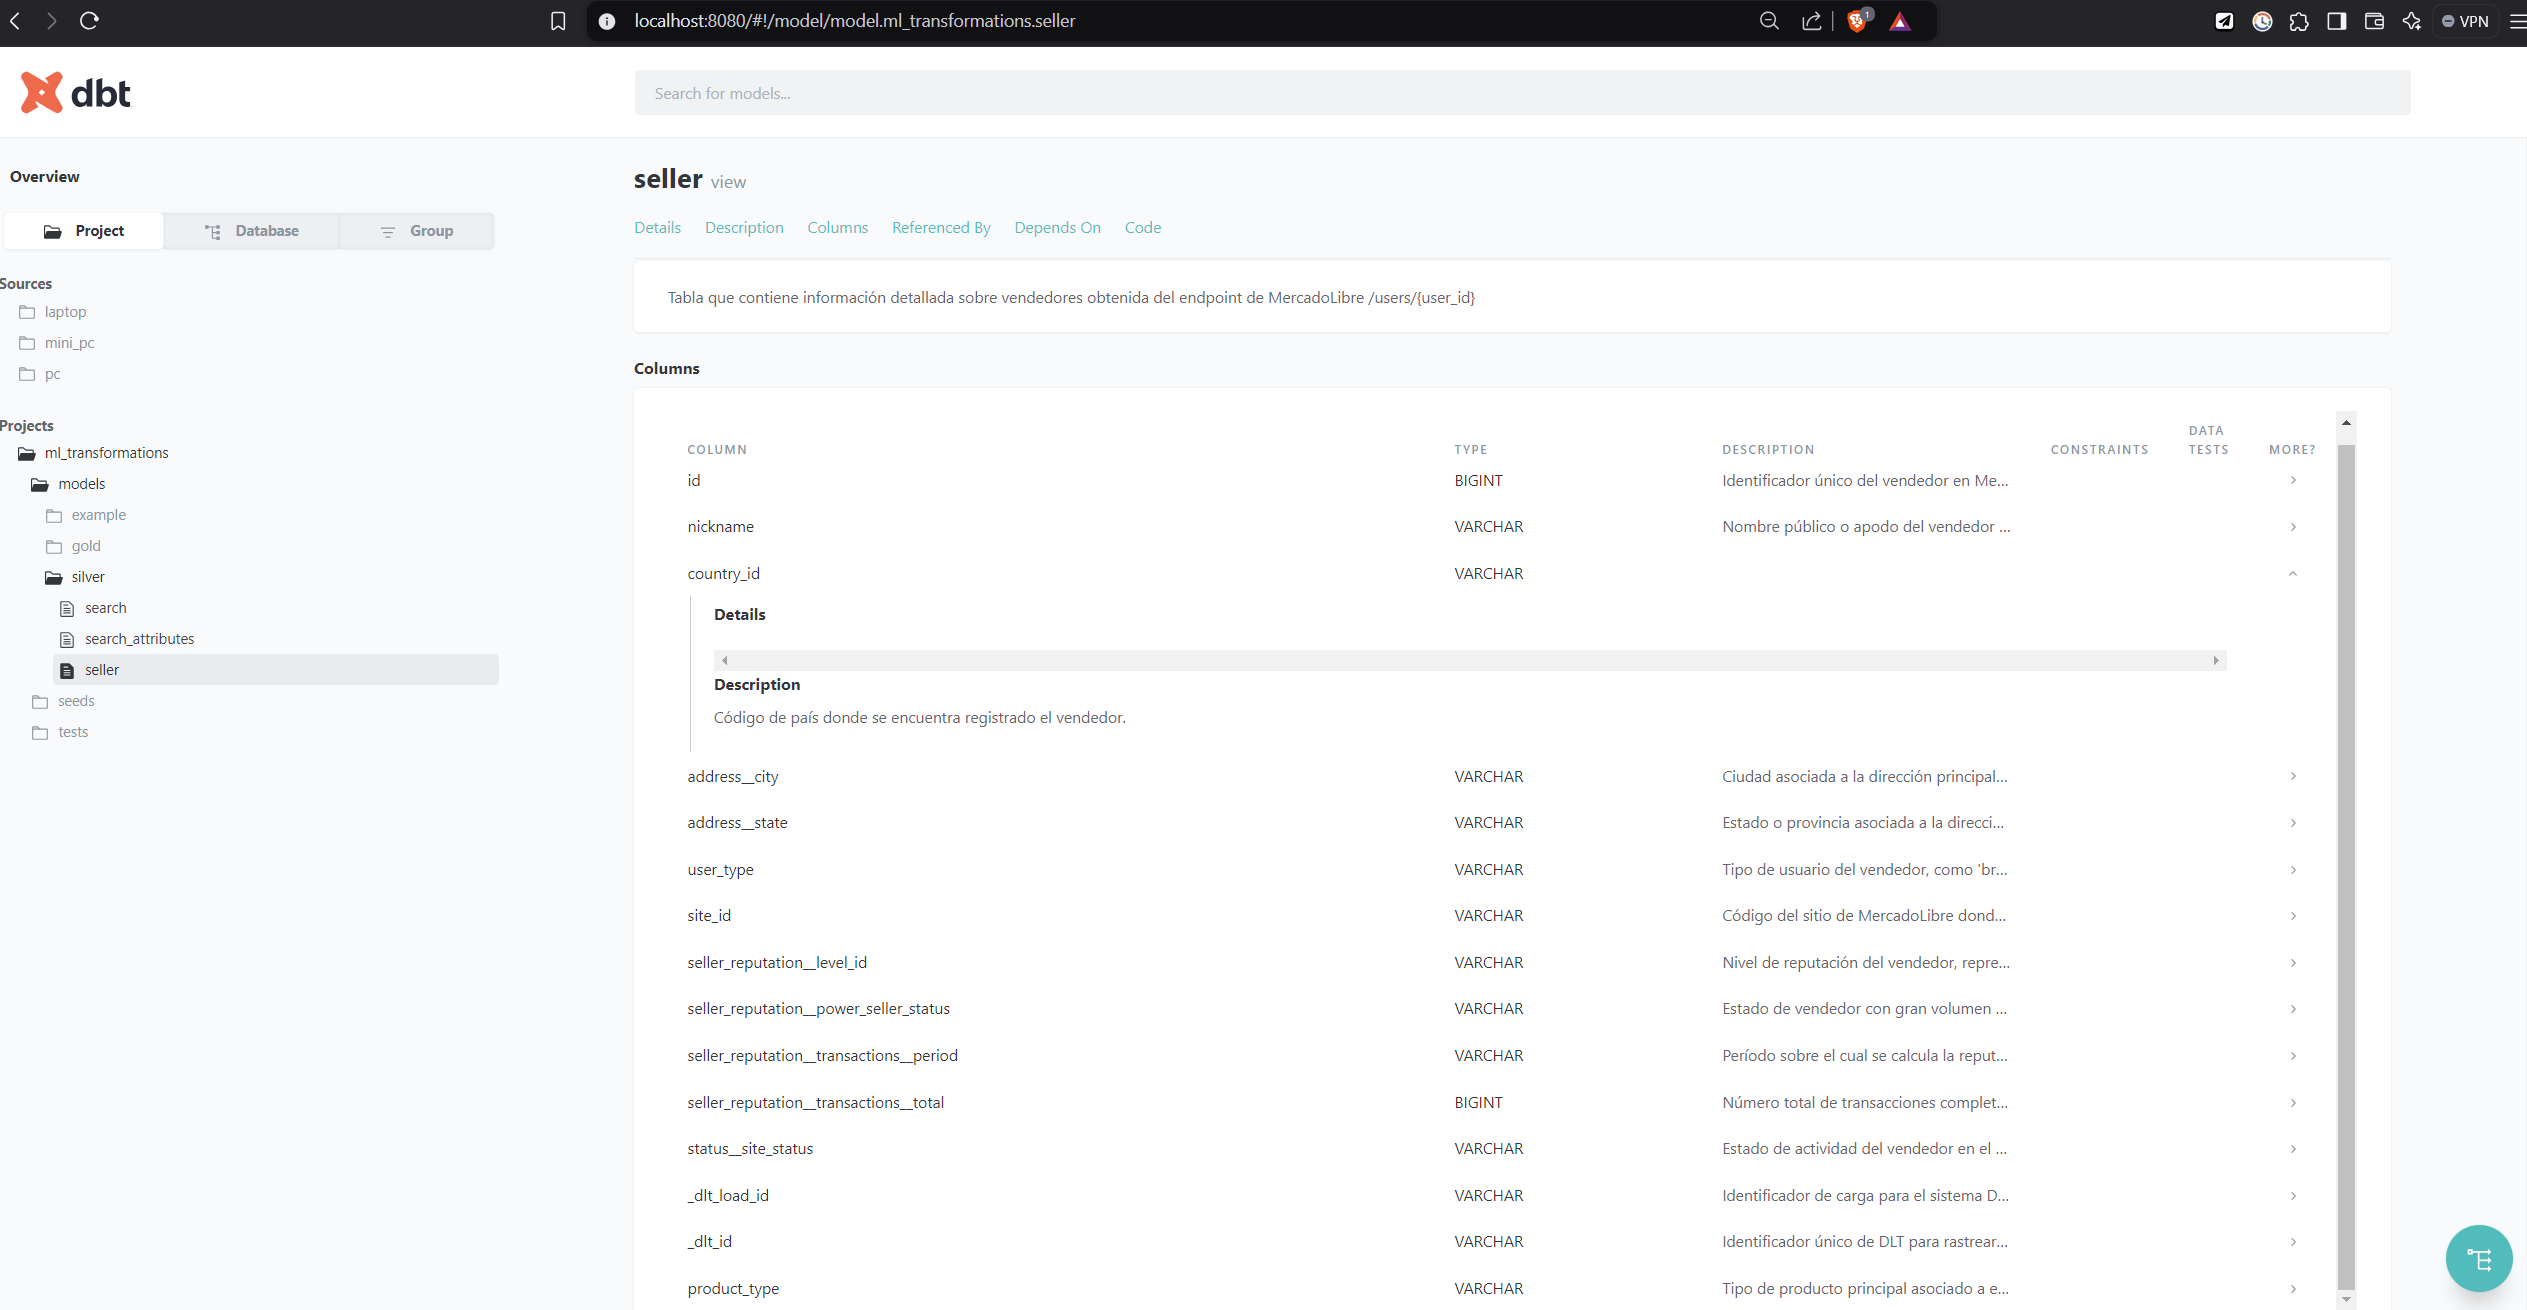

<a id="snapshots"></a> 

## 4. Snapshots:

Las snapshots son una herramienta poderosa en dbt para rastrear y versionar los cambios en las tablas de su almacén de datos.  Funcionan de manera similar a las Dimensiones de Cambio Lento (SCD) Tipo 2, donde se almacenan tanto los datos actuales como los históricos en la misma tabla, diferenciados por campos de estado y marca de tiempo.  Esto permite analizar los datos en diferentes puntos en el tiempo y comprender cómo han evolucionado.

**¿Cuándo utilizar snapshots?**

Son ideales para datasets que cambian con el tiempo, pero donde es importante mantener un registro histórico.  Un ejemplo común son las tablas de dimensiones en un modelo dimensional.  No son recomendables para datasets con alta velocidad de cambio (ej. datos transaccionales de alta frecuencia), donde otras técnicas como la captura de cambios basada en logs serían más apropiadas.

**Funcionamiento de las snapshots:**

Las snapshots se configuran en archivos `.sql` dentro del directorio `snapshots`.  Al ejecutar `dbt snapshot`, dbt compara la tabla de origen con la snapshot existente. Si detecta cambios, inserta nuevas filas en la snapshot con los datos modificados, incluyendo metadatos como `dbt_valid_from` (fecha de inicio de validez) y `dbt_valid_to` (fecha de fin de validez).


**Ejemplo de configuración en un archivo `.sql`:**

```sql
{% snapshot clientes_snapshot %}

{{
  config(
    target_schema='snapshots',
    unique_key='id_cliente',
    strategy='timestamp',
    updated_at='fecha_actualizacion'
  )
}}

select * from {{ source('origen', 'clientes') }}

{% endsnapshot %}

```

**Estrategias para detectar cambios:**

* **`timestamp`:** Se basa en un campo de marca de tiempo en la tabla de origen. Es la estrategia más simple y eficiente si se dispone de un campo confiable.
* **`check`:** Se basa en la comparación de una o más columnas especificadas.  Es útil cuando no se dispone de un campo de marca de tiempo confiable, pero puede ser menos eficiente.

**Configuraciones adicionales:**

* `invalidate_hard_deletes`:  Permite marcar registros eliminados como inactivos en la snapshot.
* `target_database`: Especifica la base de datos de destino para la snapshot.

**Metadatos generados:**

Las snapshots agregan automáticamente campos de metadatos como `dbt_valid_from`, `dbt_valid_to`, `dbt_scd_id` y `dbt_updated_at`, que facilitan la consulta y el análisis de datos históricos.

**Uso en modelos:**

Se pueden referenciar las snapshots en modelos posteriores utilizando la función `ref()`, al igual que con los modelos regulares.  Para obtener solo los registros activos, se puede filtrar por `dbt_valid_to is null`. También se pueden realizar uniones con rangos de tiempo utilizando los metadatos `dbt_valid_from` y `dbt_valid_to`.

**Consideraciones:**

Es importante considerar la frecuencia de ejecución de las snapshots en relación con la velocidad de cambio de los datos para evitar la pérdida de información. En casos de datos de alta velocidad, se deben considerar alternativas como la captura de cambios basada en logs.


Las snapshots, al conservar el historial de cambios, proporcionan una valiosa herramienta para el análisis de datos temporales y la auditoría, mejorando la comprensión de la evolución de los datos a lo largo del tiempo.


<a id="jinja"></a> 

# 5. Jinja, Macros y Paquetes

## Jinja, Macros y Paquetes en dbt: Dominando la Transformación de Datos

Jinja, las macros y los paquetes son componentes clave de dbt que permiten llevar las transformaciones de datos a un nivel superior. Jinja, como motor de plantillas, introduce la lógica programática y el dinamismo en el código SQL. Las macros, similares a las funciones en otros lenguajes de programación, encapsulan la lógica SQL reutilizable, mientras que los paquetes proporcionan colecciones preconstruidas de macros y otras utilidades que amplían aún más la funcionalidad de dbt. Dominar estos componentes es esencial para construir proyectos dbt robustos, escalables y mantenibles.

**Jinja: Lógica Programática en SQL**

Jinja es un motor de plantillas basado en texto que se integra perfectamente con dbt, permitiendo la generación dinámica de código SQL.  En lugar de escribir consultas SQL estáticas, Jinja permite insertar lógica programática, variables, filtros y estructuras de control directamente en el código SQL. Esto facilita la creación de transformaciones de datos más flexibles y adaptables a diferentes escenarios.

**Elementos clave de Jinja:**

* **Variables:**  Permiten almacenar valores y reutilizarlos en diferentes partes del código.  Se definen utilizando la etiqueta `set`.

    ```sql
    {% set nombre_esquema = 'mi_esquema' %}
    select * from {{ nombre_esquema }}.mi_tabla;
    ```

* **Filtros:** Modifican la salida de las variables o expresiones.  Se aplican utilizando el carácter `|`.

    ```sql
    {% set nombre = 'juan perez' %}
    select {{ nombre | upper }}; -- Resultado: JUAN PEREZ
    ```
    Existen numerosos filtros predefinidos en Jinja, como `lower`, `capitalize`, `replace`, `date`, entre otros.

* **Expresiones:** Se evalúan dinámicamente y se insertan en el código SQL. Se delimitan con llaves dobles `{{ ... }}`.

    ```sql
    {% set fecha_inicio = '2024-01-01' %}
    select * from mi_tabla where fecha >= '{{ fecha_inicio }}';
    ```

* **Estructuras de control:**  Permiten controlar el flujo de ejecución del código, similar a otros lenguajes de programación.

    * **`if/elif/else`:**  Ejecuta diferentes bloques de código según una condición.

        ```sql
        {% if target.name == 'produccion' %}
            select * from tabla_produccion;
        {% else %}
            select * from tabla_desarrollo;
        {% endif %}
        ```

    * **`for`:** Itera sobre una secuencia de valores.

        ```sql
        {% for columna in ['col1', 'col2', 'col3'] %}
            select {{ columna }} from mi_tabla{% if not loop.last %};{% endif %}
        {% endfor %}
        ```

* **Control de espacios en blanco:** Jinja ofrece un control preciso sobre los espacios en blanco en el SQL generado, utilizando `-` para eliminar espacios en blanco al principio o al final de las etiquetas.

    ```sql
    {%- set variable = 'valor' -%}
    select {{- variable -}}; -- Elimina espacios alrededor de "valor"
    ```


**Macros: Modularidad y Reutilización**

Las macros en dbt son similares a las funciones en otros lenguajes de programación. Permiten encapsular lógica SQL reutilizable, mejorando la modularidad y la mantenibilidad del código.  Se definen en archivos `.sql` dentro del directorio `macros` y se invocan utilizando la sintaxis `{{ macro_nombre(argumentos) }}`.

**Ejemplo de una macro:**

```sql
{% macro calcular_total_ventas(fecha_inicio, fecha_fin) %}
  select sum(precio) as total_ventas
  from ventas
  where fecha_venta between '{{ fecha_inicio }}' and '{{ fecha_fin }}';
{% endmacro %}

select {{ calcular_total_ventas('2024-01-01', '2024-01-31') }} as total_enero;
```


**Paquetes: Extendiendo la Funcionalidad de dbt**

Los paquetes de dbt son colecciones de macros, modelos y otras funcionalidades que se pueden compartir y reutilizar entre proyectos.  Se instalan utilizando el administrador de paquetes de dbt y se declaran en el archivo `packages.yml`.

**Paquetes recomendados:**

* **`dbt-utils`:** Ofrece una amplia gama de macros para diversas tareas, como la generación de claves sustitutas, manipulación de fechas, pruebas y mucho más.
* **`dbt-expectations`:**  Proporciona pruebas de calidad de datos inspiradas en la biblioteca *Great Expectations* de Python, facilitando la validación de datos.
* **`codegen`:**  Automatiza la generación de código YAML para modelos y fuentes, ahorrando tiempo y esfuerzo en la configuración de proyectos.

**Funciones Jinja específicas de dbt:**

dbt proporciona funciones Jinja adicionales que facilitan la interacción con el entorno de dbt y la base de datos.

* **`target`:** Accede a la configuración del target actual (ej. `target.schema`, `target.name`, `target.type`).  Permite adaptar el código a diferentes entornos.
* **`this`:**  Devuelve la referencia completa del modelo actual, útil para modelos incrementales y otras situaciones donde se necesita la referencia completa.
* **`var`:** Accede a las variables definidas en el archivo `dbt_project.yml`.  Permite centralizar la configuración del proyecto.
* **`env_var`:** Accede a las variables de entorno, útil para configurar credenciales y otros parámetros sensibles sin incluirlos directamente en el código.


Mediante la combinación estratégica de Jinja, macros y paquetes, se puede lograr un control total sobre las transformaciones de datos en dbt, creando código modular, reutilizable, eficiente y adaptado a las necesidades específicas de cada proyecto.
